<a href="https://colab.research.google.com/github/MahdiEsrafili/image_segmentation/blob/master/skin_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
! mkdir ~/.kaggle
% cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nodoubttome/skin-cancer9-classesisic
!unzip -q skin-cancer9-classesisic.zip -d data/

 99% 777M/786M [00:08<00:00, 90.4MB/s]
100% 786M/786M [00:08<00:00, 97.7MB/s]


In [3]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report
%matplotlib inline

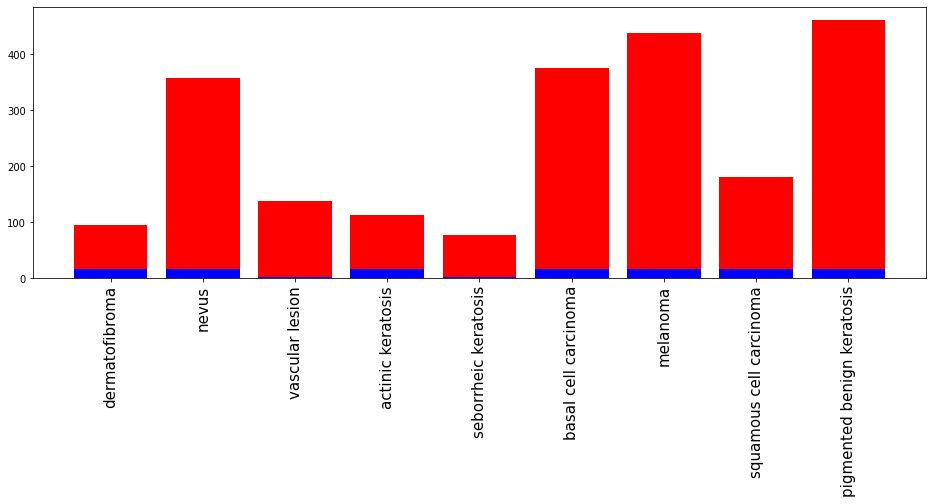

In [4]:
path = '/content/data/Skin cancer ISIC The International Skin Imaging Collaboration'
branches = ['Test', 'Train']
distributions = dict()
for branch in branches:
  diseases = dict()
  for disease in os.listdir(os.path.join(path, branch)):
    diseases[disease] = len(os.listdir(os.path.join(path, branch, disease)))
  distributions[branch] = diseases

plt.figure(figsize=(16, 5))
plt.bar(distributions['Train'].keys(), distributions['Train'].values(), color='r')
plt.bar(distributions['Test'].keys(), distributions['Test'].values(), color='b')
plt.xticks(rotation = 90, fontsize=15) # Rotates X-Axis Ticks by 45-degrees
plt.show()


In [5]:
distributions

{'Test': {'actinic keratosis': 16,
  'basal cell carcinoma': 16,
  'dermatofibroma': 16,
  'melanoma': 16,
  'nevus': 16,
  'pigmented benign keratosis': 16,
  'seborrheic keratosis': 3,
  'squamous cell carcinoma': 16,
  'vascular lesion': 3},
 'Train': {'actinic keratosis': 114,
  'basal cell carcinoma': 376,
  'dermatofibroma': 95,
  'melanoma': 438,
  'nevus': 357,
  'pigmented benign keratosis': 462,
  'seborrheic keratosis': 77,
  'squamous cell carcinoma': 181,
  'vascular lesion': 139}}

In [6]:
import torchvision
import torch
from torchvision import transforms as T
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

In [7]:
train_transforms = T.Compose([
                        T.Resize((224, 224)),
                        T.RandomVerticalFlip(0.3),
                        T.RandomHorizontalFlip(0.3),
                        T.ToTensor(),
                        T.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225])
])

test_transforms = T.Compose([
                        T.Resize((224, 224)),
                        T.ToTensor(),
                        T.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225])
])

In [8]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(path, 'Train'), 
                                                 transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder(os.path.join(path, 'Test'), 
                                                 transform=test_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
from functools import reduce
reduce(lambda x,y: x+y, distributions['Train'].values())

2239

In [10]:
total_samples = 2239
weights_named = {k:v/total_samples for (k,v) in distributions['Train'].items()}
weights_named

{'actinic keratosis': 0.05091558731576597,
 'basal cell carcinoma': 0.16793211255024565,
 'dermatofibroma': 0.04242965609647164,
 'melanoma': 0.19562304600267977,
 'nevus': 0.15944618133095131,
 'pigmented benign keratosis': 0.20634211701652524,
 'seborrheic keratosis': 0.03439035283608754,
 'squamous cell carcinoma': 0.08083966056275123,
 'vascular lesion': 0.062081286288521664}

In [11]:
weights = dict()
for k, v in train_loader.dataset.class_to_idx.items():
  weights[v] = weights_named[k]
weights

{0: 0.05091558731576597,
 1: 0.16793211255024565,
 2: 0.04242965609647164,
 3: 0.19562304600267977,
 4: 0.15944618133095131,
 5: 0.20634211701652524,
 6: 0.03439035283608754,
 7: 0.08083966056275123,
 8: 0.062081286288521664}

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
model = torchvision.models.resnet18(pretrained=True, progress=True)

In [14]:
num_classes = 9
model.fc = nn.Linear(model.fc.in_features, num_classes)
torch.nn.init.xavier_uniform_(model.fc.weight);
model = model.to(device)

In [15]:
# param_group = True
lr = 1e-3
# if param_group:
#     params_1x = [param for name,param in model.named_parameters()
#                 if name not in ['fc.weight','fc.bias']]
#     optimizer = torch.optim.SGD([{'params':params_1x},
#                                {'params':model.fc.parameters(), 'lr':0.001}],
#                              lr=lr, weight_decay=0.001)
# else:
#     optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_weights = torch.tensor(list(weights.values()))
# criterion = nn.CrossEntropyLoss(weight=loss_weights).to(device)
criterion = nn.CrossEntropyLoss().to(device)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [24]:
def train(model, trainset, criterion, optimizer, lr_scheduler, num_epochs=10, batch_size=32):
  loss_history = list()
  for epoch in range(num_epochs):
    model.train()
    train_size = int(0.9*len(trainset))
    valid_size = len(trainset) - train_size
    train_ds, valid_ds = torch.utils.data.random_split(trainset, [train_size, valid_size],
                 generator=torch.Generator().manual_seed(42))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    pbar = tqdm(train_loader)
    epoch_losses = np.array([])
    train_corrects = 0
    train_img_passed = 0
    for images, labels in pbar:
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      out = model(images)
      loss = criterion(out, labels)
      loss.backward()
      optimizer.step()
      pred = out.argmax(dim=1).cpu().numpy()
      train_corrects += (pred==labels.cpu().numpy()).sum()
      train_img_passed += pred.shape[0]
      train_accuracy = train_corrects/train_img_passed
      epoch_losses = np.append(epoch_losses, loss.item())
      pbar.set_description(f'epoch {epoch+1}/{num_epochs},\
                            accuracy={train_accuracy:.4f}, error={epoch_losses.mean():.4f} ')
    loss_history.append(epoch_losses.mean())
    lr_scheduler.step()
    with torch.no_grad():
      model.eval()
      valid_corrects = 0
      valid_loss = np.array([])
      for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out = model(images)
        pred = out.argmax(dim=1).cpu().numpy()
        valid_corrects += (pred==labels.cpu().numpy()).sum()
        loss = criterion(out, labels)
        valid_loss = np.append(valid_loss, loss.item())
      valid_accuracy = valid_corrects/len(valid_ds)
      valid_loss = valid_loss.mean()
      print(f'val accuracy = {valid_accuracy:.4f}, val loss ={valid_loss:.4f}')
  return model, loss_history


In [25]:
model, loss_history = train(model, train_dataset, criterion, optimizer, lr_scheduler, num_epochs=30)


val accuracy = 0.7455, val loss =0.7046



val accuracy = 0.7455, val loss =0.6752



val accuracy = 0.7545, val loss =0.7641



val accuracy = 0.7589, val loss =0.7066



val accuracy = 0.7321, val loss =0.7258



val accuracy = 0.7411, val loss =0.8504


KeyboardInterrupt: ignored

In [ ]:
with open('/content/model.pt', 'wb') as f:
  torch.save(model , f)
!cp /content/model.pt /content/drive/MyDrive/skin_cancer/

In [98]:

def test(model, dataloaders, criterion):
  with torch.no_grad():
    all_preds = np.array([])
    ground_truth = np.array([])
    losses = 0
    model.eval()
    for (images, labels) in dataloaders:
      images = images.to(device)
      labels = labels.to(device)
      preds = model(images)
      loss = criterion(preds, labels)
      preds = preds.argmax(axis=1)
      all_preds = np.append(all_preds, preds.cpu().numpy().astype(int))
      ground_truth = np.append(ground_truth, labels.cpu().numpy().astype(int))
      losses +=  loss.item()
  print(losses/ground_truth.shape[0])
  print(classification_report(ground_truth.astype(np.int16), all_preds.astype(np.int16), target_names=list(weights_named.keys())))

In [99]:
test(model, test_loader, criterion)

0.06083749057882923
                            precision    recall  f1-score   support

            dermatofibroma       1.00      0.06      0.12        16
                     nevus       0.63      0.75      0.69        16
           vascular lesion       1.00      0.38      0.55        16
         actinic keratosis       0.27      0.19      0.22        16
      seborrheic keratosis       0.34      0.94      0.50        16
      basal cell carcinoma       0.57      0.81      0.67        16
                  melanoma       0.00      0.00      0.00         3
   squamous cell carcinoma       0.60      0.38      0.46        16
pigmented benign keratosis       0.75      1.00      0.86         3

                  accuracy                           0.50       118
                 macro avg       0.57      0.50      0.45       118
              weighted avg       0.62      0.50      0.46       118



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
